In [1]:
from keras.layers import RepeatVector
from keras.layers.core import Dropout, Dense, Activation
from keras.layers.recurrent import LSTM, GRU
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from sklearn.preprocessing import MinMaxScaler
import math
import time
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import fbeta_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from utils import *
from scipy import stats

Using TensorFlow backend.


In [18]:
def get_data():
    path = "fastStorage/fastStorage/2013-8/1.csv"
    df = pd.read_csv(path, sep=';\t')
    df = df.drop(['CPU cores', 'Memory capacity provisioned [KB]'], 1)
    if(df.isnull().sum().sum()):
        df = df.fillna(df.mean())
    return df

In [19]:
def get_benchmark():
    path = "datasets/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_59.csv"
    #path = "ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark_all.csv"
    df = pd.read_csv(path, sep=',')
    df = df.drop(['timestamp', 'is_anomaly'], 1)
    if(df.isnull().sum().sum()):
        df = df.fillna(df.mean())
    return df

In [4]:
def make_data_windows(data, window_length=12):
    train_windows = []
    for window_start in range(0, len(data) - window_length + 1):
        window_end = window_start + window_length
        window_range = range(window_start, window_end)
        window = list(data[window_range])
        train_windows.append(window)
    return train_windows

In [5]:
def orchestrate_data(data, window_size, ltrain, lvalid, ltest):
    scaler = MinMaxScaler(feature_range=(0, 1))
    signal = scaler.fit_transform(data)
    length = signal.shape[0]
    slicet = int(ltrain*(length))
    slicev = slicet + int(lvalid*(length))
    signal_train = signal[:slicet]
    signal_valid = signal[slicet:slicev]
    signal_test = signal[slicev:length]
    xtrain = np.array(make_data_windows(signal_train, window_size))
    xvalid = np.array(make_data_windows(signal_valid, window_size))
    xtest = np.array(make_data_windows(signal_test, window_size))
    return xtrain, xvalid, xtest

In [6]:
def modelgru(window_length, input_dim=1, hidden_dim=12):
    input_length = window_length
    m = Sequential()
    m.add(GRU(units=2 * hidden_dim, activation='relu', input_shape=(input_length, input_dim), return_sequences=True))
    m.add(Dropout(rate=0.2))
    m.add(GRU(units=hidden_dim, activation='relu', input_shape=(input_length, input_dim), return_sequences=True))
    m.add(Dropout(rate=0.1))
    m.add(GRU(units=hidden_dim, activation='relu', input_shape=(input_length, input_dim),return_sequences=True))
    m.add(Dropout(rate=0.1))
    m.add(GRU(units=2 * hidden_dim, activation='relu', input_shape=(input_length, input_dim),return_sequences=True))
    m.add(Dropout(rate=0.2))
    #m.add(Dense(1, activation='linear'))
    m.add(Dense(input_dim))
    m.compile(loss='mse', optimizer='adam')
    return m

In [7]:
def plot_reconstruction(history):
    plt.figure(figsize=(22, 4))
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='best')
    plt.show()
    return

In [9]:
class model_lstm():
    def __init__(self, window_size, input_dim, hidden_dim):
        
        self.model = modelgru(window_size, input_dim, hidden_dim)
        self.window_size = window_size
        self.train_time = None
        self.threshold = None
        self.update_time = 0
        self.update_count = 0
        self.input_dim = input_dim
        self.checkpointer = ModelCheckpoint(filepath="lstm.autoencoder.weights.best.hdf5",
                                       verbose=1, save_best_only=True)
        self.earlystopper = EarlyStopping(monitor='val_loss', patience=5, verbose=0)
        
    def train_model(self, x_train, x_valid, epochs):

        tbCallBack = TensorBoard(log_dir='lstm.autoencoder.tb.graph',
                                 histogram_freq=0, write_graph=True, write_images=True)

        start_time = time.time()
        history = self.model.fit(x_train, x_train, batch_size=self.window_size,
                                epochs=epochs, validation_data=(x_valid, x_valid), 
                                callbacks=[self.checkpointer, self.earlystopper, tbCallBack], verbose=0).history
        end_time = time.time()
        self.train_time = (end_time - start_time)
        plot_reconstruction(history)
        
        pred_x = self.model.predict(x_train)
        max_mae_of_predictions = np.squeeze(np.max(np.square(x_train[:,:,:] - pred_x[:,:,:]), axis=1))
        max_mae_threshold = np.mean(max_mae_of_predictions) + np.std(max_mae_of_predictions)
        self.threshold = max_mae_threshold
        
        return history
    
    def train_batch(self, data, epochs, slicetr, slicev, slices):
        xtrain, xvalid, xtest = orchestrate_data(dataa, window_size, slicetr, slicev, slices)
        return instance.train_model(xtrain, xvalid, epochs) 
    
    def plot_scope(self, data):
        xtrain, xvalid, xtest = orchestrate_data(data, window_size, 1.0, 0.0, 0.0)
        predx = self.model.predict(xtrain)
        
        scaler = MinMaxScaler(feature_range=(0, 1))
        signal = scaler.fit_transform(data)
        
        if signal.shape[1] > 1:
            investigate_multi_errors(xtrain, predx, signal, self.window_size)
        else:
            investigate_errors(xtrain, predx, signal, self.window_size)
        return
              
    def predict(self, data):
        return self.model.predict(data)
    
    def update_threshold(self, data):
        xtrain, xvalid, xtest = orchestrate_data(data, window_size, 1.0, 0.0, 0.0)
        predx = self.model.predict(xtrain)
        
        max_mae_of_predictions = np.squeeze(np.max(np.square(xtrain[:, :, :] - predx[:, :, :]), axis=1))
        
        max_mae_threshold = np.mean(max_mae_of_predictions) + np.std(max_mae_of_predictions)
        self.threshold = max_mae_threshold
        return
        
    def is_anomalous(self, data):
        y = np.reshape(np.array(data), (1, self.window_size, self.input_dim))
        pred = self.model.predict(y)
            #print(pred, y)
            #predicted hmm
            #max for each window is taken
            #avg for each window is taken
            #squeeze just eliminated redundant dimention of 1
            #max for each window we have and mean for each window we have
        max_mae = np.squeeze(np.max(np.square(y[:,:,:] - pred[:,:,:]), axis=1))

        if(self.threshold > max_mae):
            return "anomaly"
        else:
            return "benign"
    
    def micro_update(self, point, epochs):
        y = np.reshape(np.array(point), (1, self.window_size, self.input_dim))
        start_time = time.time()
        self.model.fit(y, y, batch_size=self.window_size, epochs=epochs, verbose=0)
        end_time = time.time()
        self.update_time += (end_time - start_time)
        self.update_count += 1
        return

In [10]:
def investigate_errors(x_test, pred_x_test, signal_test=None, window_length=None):
    max_mae_of_predictions = np.squeeze(np.max(np.square(x_test[:,1:,:] - pred_x_test[:,1:,:]), axis=1))
    avg_mae_of_predictions = np.squeeze(np.mean(np.square(x_test[:,1:,:] - pred_x_test[:,1:,:]), axis=1))
    df = pd.DataFrame(data=np.c_[max_mae_of_predictions, avg_mae_of_predictions], 
                  columns=['max_mae_of_predictions', 'avg_mae_of_predictions'])
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))
    df['max_mae_of_predictions'].plot.hist(bins=50, ax=ax[0])
    df['max_mae_of_predictions'].plot.kde(secondary_y=True, ax=ax[0])
    ax[0].set_title('max_mae_of_predictions distribution')
    df['avg_mae_of_predictions'].plot.hist(bins=50, ax=ax[1])
    df['avg_mae_of_predictions'].plot.kde(secondary_y=True, ax=ax[1])
    ax[1].set_title('avg_mae_of_predictions distribution');
    kernel_max_mae = stats.gaussian_kde(df['max_mae_of_predictions'].values)
    kernel_avg_mae = stats.gaussian_kde(df['avg_mae_of_predictions'].values)
    df['pdf_max_mae'] = df['max_mae_of_predictions'].map(lambda x: kernel_max_mae.integrate_box(x - 1e-8, x + 1e-8))
    df['pdf_avg_mae'] = df['avg_mae_of_predictions'].map(lambda x: kernel_avg_mae.integrate_box(x - 1e-8, x + 1e-8))
    max_mae_threshold = np.mean(max_mae_of_predictions) + np.std(max_mae_of_predictions)
    
    plt.figure(figsize=(22, 4))
    df['max_mae_of_predictions'].plot()
    plt.axhline(y=max_mae_threshold, color='orange', label='threshold')
    plt.legend(loc='best')
    plt.title('max_mae_of_predictions_per_window')
    plt.grid(True, which='both');

    pred_outlier_indices = np.where(max_mae_of_predictions > max_mae_threshold)[0]
    #print(pred_outlier_indices)
    plt.figure(figsize=(22, 4))
    plt.plot(signal_test)
    for w_index in pred_outlier_indices:
        plt.fill_betweenx((signal_test.min(), signal_test.max()), w_index, w_index + window_length - 1, alpha=0.1, color='red')
    plt.title('Anomalous Windows')
    plt.grid(True);

In [11]:
def investigate_multi_errors(x_test, pred_x_test, signal_test, window_length):
    
    #max for each window is taken
    #avg for each window is taken
    #squeeze just eliminated redundant dimention of 1
    #max for each window we have and mean for each window we have
    max_mae_of_predictions = np.squeeze(np.max(np.square(x_test[:,:,:] - pred_x_test[:,:,:]), axis=1))
    
    max_mae_threshold = np.mean(max_mae_of_predictions) + np.std(max_mae_of_predictions)
    #is your max error inside window greater than our threshold
    pred_outlier_indices = np.where(max_mae_of_predictions > max_mae_threshold)[0]
    
    plt.figure(figsize=(22, 4))
    plt.plot(signal_test)
    for w_index in pred_outlier_indices:
        plt.fill_betweenx((signal_test.min(), signal_test.max()), w_index, w_index + window_length - 1, alpha=0.1, color='orange')
    plt.title('Anomalous Windows')

In [12]:
def get_data_actual():
    path = "mem.txt"
    df = pd.read_csv(path, sep=',', header=None)
    df = df.drop([0], 1)
    if(df.isnull().sum().sum()):
        df = df.fillna(df.mean())
    return df


Epoch 00001: val_loss improved from inf to 0.06467, saving model to lstm.autoencoder.weights.best.hdf5

Epoch 00002: val_loss improved from 0.06467 to 0.02340, saving model to lstm.autoencoder.weights.best.hdf5

Epoch 00003: val_loss improved from 0.02340 to 0.01230, saving model to lstm.autoencoder.weights.best.hdf5

Epoch 00004: val_loss improved from 0.01230 to 0.00466, saving model to lstm.autoencoder.weights.best.hdf5

Epoch 00005: val_loss improved from 0.00466 to 0.00263, saving model to lstm.autoencoder.weights.best.hdf5

Epoch 00006: val_loss improved from 0.00263 to 0.00249, saving model to lstm.autoencoder.weights.best.hdf5

Epoch 00007: val_loss improved from 0.00249 to 0.00161, saving model to lstm.autoencoder.weights.best.hdf5

Epoch 00008: val_loss improved from 0.00161 to 0.00119, saving model to lstm.autoencoder.weights.best.hdf5

Epoch 00009: val_loss did not improve from 0.00119

Epoch 00010: val_loss did not improve from 0.00119


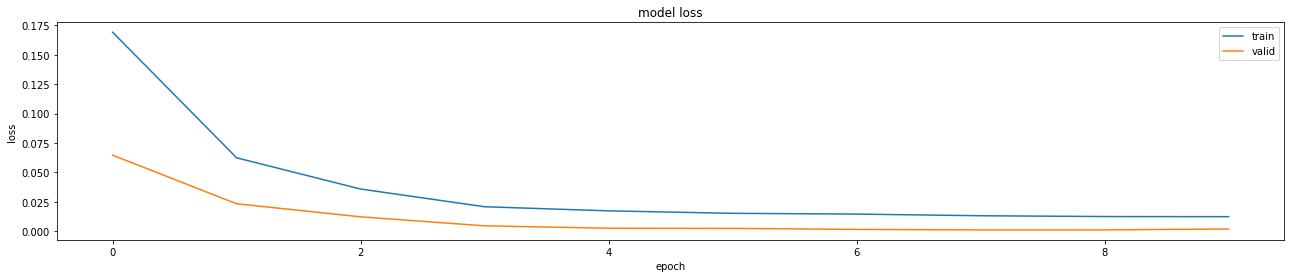


Epoch 00001: val_loss did not improve from 0.00119

Epoch 00002: val_loss did not improve from 0.00119

Epoch 00003: val_loss did not improve from 0.00119

Epoch 00004: val_loss did not improve from 0.00119

Epoch 00005: val_loss did not improve from 0.00119


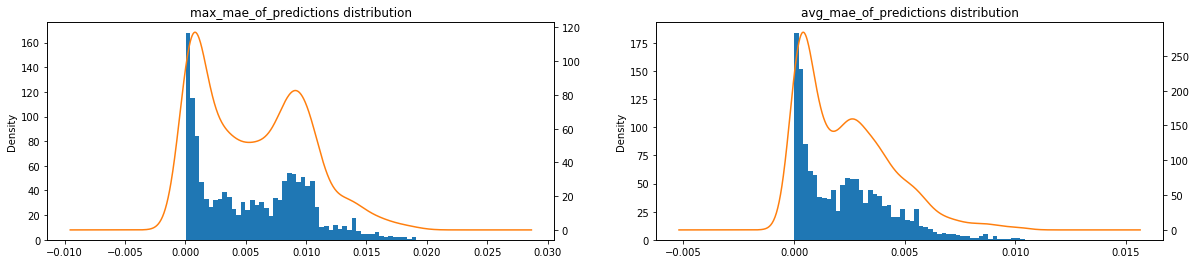

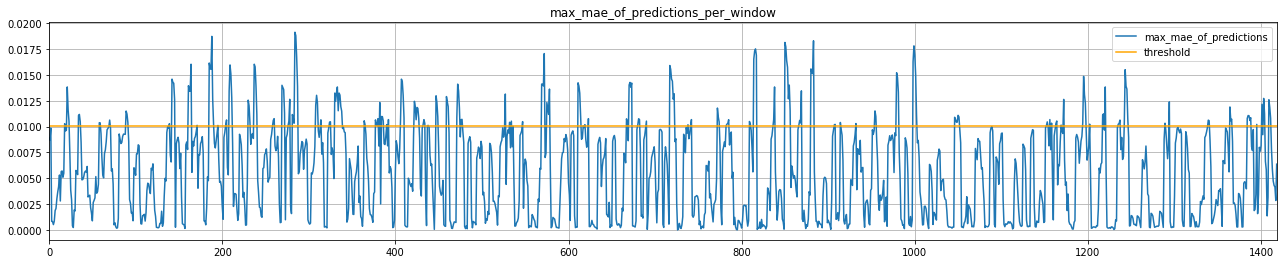

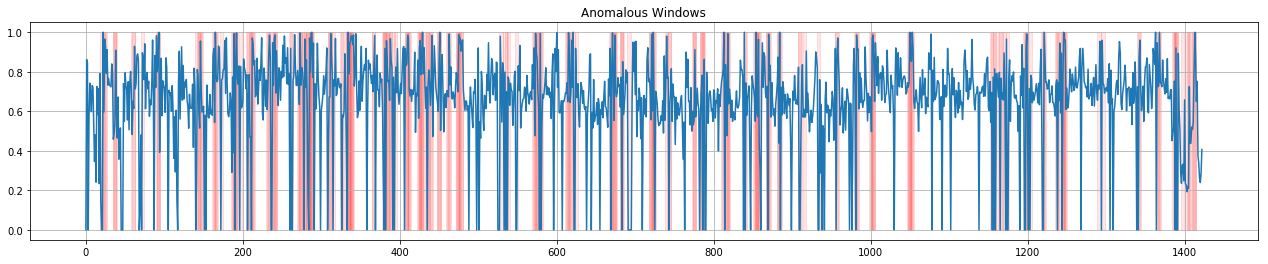

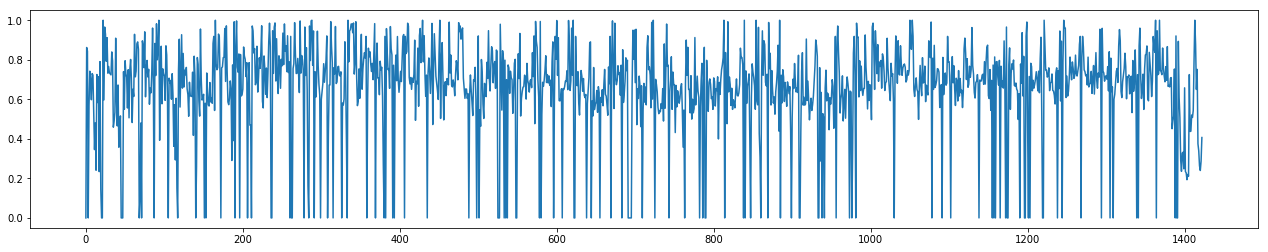

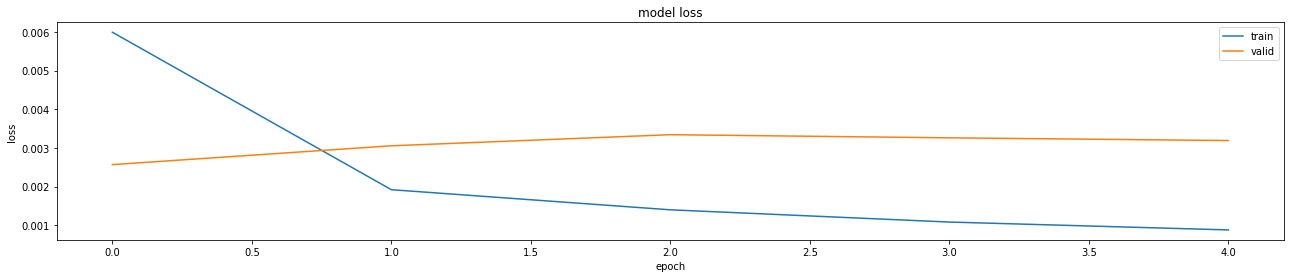

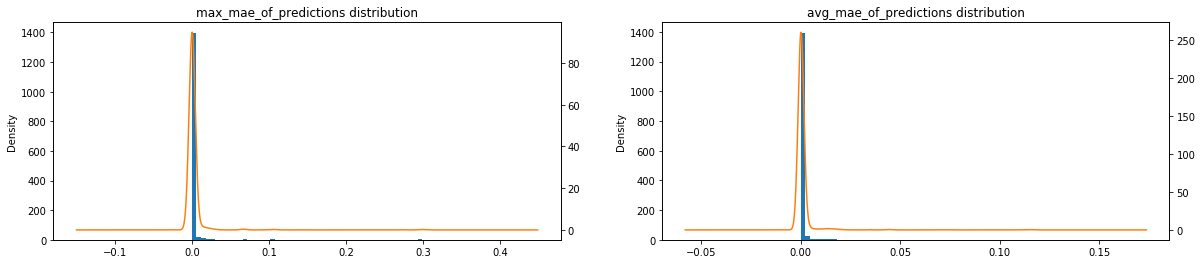

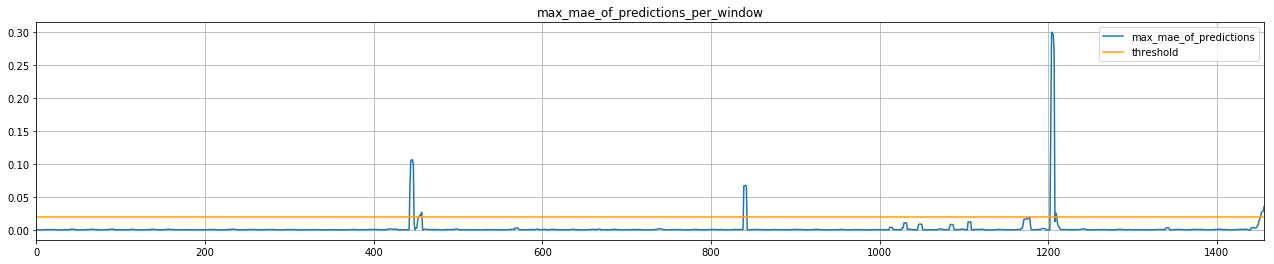

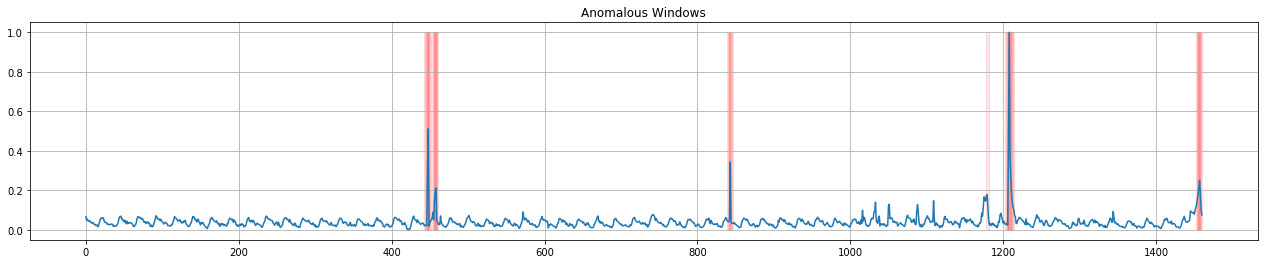

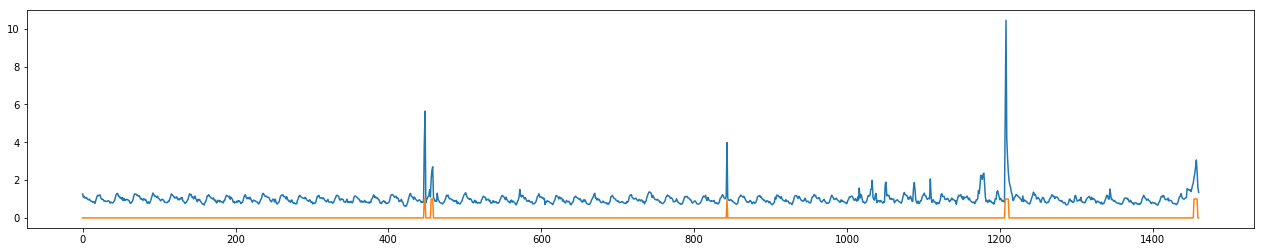

In [20]:
if __name__ == "__main__":
    window_size = 5
    input_dim = 1
    hidden_dim = 12
    instance = model_lstm(window_size, input_dim, hidden_dim)
    
    #dataa = get_data_actual()
    dataa = get_benchmark()
    
    xtrain, xvalid, xtest = orchestrate_data(dataa, window_size, 0.70, 0.15, 0.15)
    instance.train_model(xtrain, xvalid, 10)
    instance.plot_scope(dataa)

    plt.figure(figsize=(22, 4))
    plt.plot(dataa)
    
    path = "datasets/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_60.csv"
    df = pd.read_csv(path, sep=',')
    if(df.isnull().sum().sum()):
        df = df.fillna(df.mean())
    df = df.drop(['timestamp'], 1)
    df2 = df.drop(['is_anomaly'], 1)
    
    xtrain, xvalid, xtest = orchestrate_data(df2, window_size, 0.70, 0.15, 0.15)
    instance.train_model(xtrain, xvalid, 5)
    instance.plot_scope(df2)

    plt.figure(figsize=(22, 4))
    plt.plot(df)

In [14]:
input_dim = 1
window = []
for index, row in df.iterrows():
    item = row.values[0]
    if len(window) < 5:
        window.append(item)
        if len(window) == 5:
                print(item, instance.is_anomalous(window))
    else:
        #it was already 5
        #slide
        window.pop(0)
        window.append(item)
        #pred = instance.predict(item)
        print(item, instance.is_anomalous(window))
        continue

1.0519444444444002 benign
1.08 benign
1.0088888888889 benign
0.96361111111111 benign
0.95888888888889 benign
0.995 benign
0.91444444444444 benign
0.8875 benign
0.8875 benign
0.82472222222222 benign
0.85472222222222 benign
0.84305555555556 benign
0.76555555555556 benign
0.89277777777778 benign
1.0186111111111 benign
1.1577777777778002 benign
1.1977777777778 benign
1.1680555555556 benign
1.2141666666667 benign
1.2066666666666999 benign
1.0477777777778001 benign
0.98166666666667 benign
0.99277777777778 benign
0.96333333333333 benign
0.88805555555556 benign
0.90861111111111 benign
0.87333333333333 benign
0.87027777777778 benign
0.87472222222222 benign
0.90666666666667 benign
0.9030555555555599 benign
0.87194444444444 benign
0.78277777777778 benign
0.83527777777778 benign
0.80916666666667 benign
0.79222222222222 benign
0.81472222222222 benign
0.8825 benign
0.94333333333333 benign
1.1177777777778002 benign
1.2472222222221998 benign
1.2894444444444 benign
1.2825 benign
1.14 benign
1.145555555

1.1638888888888999 benign
1.0908333333333 benign
1.12 benign
1.1544444444444 benign
1.0391666666666999 benign
1.0625 benign
1.0105555555555998 benign
0.86583333333333 benign
0.91416666666667 benign
0.8875 benign
0.9825 benign
0.86166666666667 benign
0.83388888888889 benign
0.66944444444444 benign
0.6305555555555601 benign
0.64861111111111 benign
0.6105555555555601 benign
0.68083333333333 benign
0.77722222222222 benign
0.96444444444444 benign
1.0961111111111 benign
1.2566666666667 benign
1.2963888888889 benign
1.1469444444444 benign
1.1086111111111001 benign
1.105 benign
0.97583333333333 benign
1.1030555555556 benign
1.0325 benign
0.97277777777778 benign
0.935 benign
0.88833333333333 benign
0.91111111111111 benign
0.94944444444444 benign
0.95305555555556 benign
0.88722222222222 benign
0.81083333333333 benign
0.84722222222222 benign
0.86861111111111 benign
0.81027777777778 benign
3.9380555555556 benign
5.6463888888889 benign
0.79694444444444 benign
0.95388888888889 benign
1.05 benign
1.1

0.78361111111111 benign
0.83472222222222 benign
0.86694444444444 benign
0.9030555555555599 benign
0.86555555555556 benign
0.7825 benign
0.74138888888889 benign
0.73055555555556 benign
0.73694444444444 benign
0.75027777777778 benign
0.79388888888889 benign
0.85388888888889 benign
0.95083333333333 benign
1.0363888888889 benign
1.1558333333333 benign
1.1236111111111002 benign
1.1133333333333 benign
1.1961111111111002 benign
0.9925 benign
0.91888888888889 benign
1.0886111111111 benign
0.98527777777778 benign
0.91638888888889 benign
0.90194444444444 benign
0.87333333333333 benign
0.90888888888889 benign
0.89 benign
0.88944444444444 benign
0.92861111111111 benign
0.79277777777778 benign
0.78944444444444 benign
0.77333333333333 benign
0.80138888888889 benign
0.73777777777778 benign
0.75861111111111 benign
0.83916666666667 benign
1.0280555555556 benign
1.0594444444444 benign
1.1338888888888998 benign
1.2255555555556001 benign
1.1844444444444 benign
1.0661111111111 benign
1.0244444444444 benign

0.9525 benign
0.88 benign
0.92583333333333 benign
0.86694444444444 benign
0.84111111111111 benign
5.646111111111099 benign
10.452777777778 benign
4.2377777777778 benign
3.1922222222222 benign
2.4441666666667 benign
1.9872222222222 benign
1.7388888888889 benign
1.6255555555556003 benign
1.3352777777778002 benign
1.2663888888888999 benign
0.92777777777778 benign
0.93666666666667 benign
1.1002777777778001 benign
1.1166666666667 benign
1.2252777777778001 benign
1.2283333333333 benign
1.1683333333333001 benign
1.1452777777778 benign
1.0908333333333 benign
1.0705555555556 benign
0.99361111111111 benign
0.95666666666667 benign
0.875 benign
1.1641666666666999 benign
0.86611111111111 benign
0.94944444444444 benign
0.92416666666667 benign
0.87583333333333 benign
0.87416666666667 benign
0.79777777777778 benign
0.76388888888889 benign
0.76305555555556 benign
0.73444444444444 benign
0.83888888888889 benign
0.96027777777778 benign
1.0697222222221998 benign
1.2197222222222 benign
1.3647222222222 beni

In [15]:
input_dim = 1
window = []
for index, row in df.iterrows():
    item = row.values[0]
    if len(window) < 5:
        window.append(item)
        if len(window) == 5:
                print(item, instance.is_anomalous(window))
                instance.micro_update(window, 3)
    else:
        #it was already 5
        #slide
        window.pop(0)
        window.append(item)
        #pred = instance.predict(item)
        print(item, instance.is_anomalous(window))
        instance.micro_update(window, 3)
        continue

1.0519444444444002 benign
1.08 benign
1.0088888888889 benign
0.96361111111111 benign
0.95888888888889 benign
0.995 benign
0.91444444444444 benign
0.8875 benign
0.8875 anomaly
0.82472222222222 benign
0.85472222222222 benign
0.84305555555556 anomaly
0.76555555555556 benign
0.89277777777778 benign
1.0186111111111 benign
1.1577777777778002 benign
1.1977777777778 benign
1.1680555555556 benign
1.2141666666667 benign
1.2066666666666999 anomaly
1.0477777777778001 anomaly
0.98166666666667 benign
0.99277777777778 benign
0.96333333333333 anomaly
0.88805555555556 anomaly
0.90861111111111 anomaly
0.87333333333333 benign
0.87027777777778 benign
0.87472222222222 benign
0.90666666666667 benign
0.9030555555555599 benign
0.87194444444444 anomaly
0.78277777777778 anomaly
0.83527777777778 anomaly
0.80916666666667 anomaly
0.79222222222222 anomaly
0.81472222222222 anomaly
0.8825 benign
0.94333333333333 benign
1.1177777777778002 benign
1.2472222222221998 benign
1.2894444444444 benign
1.2825 benign
1.14 anoma

1.1127777777778 benign
1.0883333333333 anomaly
1.0358333333333 anomaly
1.0033333333333 anomaly
0.97916666666667 anomaly
0.87333333333333 anomaly
0.83944444444444 anomaly
0.91055555555556 anomaly
0.84388888888889 anomaly
0.82972222222222 anomaly
0.87138888888889 anomaly
0.93055555555556 anomaly
0.82027777777778 anomaly
0.84888888888889 anomaly
0.82222222222222 anomaly
0.81388888888889 anomaly
0.82944444444444 anomaly
0.77472222222222 anomaly
0.84833333333333 anomaly
0.81333333333333 anomaly
0.99305555555556 anomaly
1.0302777777778 benign
1.1536111111111003 benign
1.2175 benign
1.0836111111111 benign
1.1288888888889 benign
1.0480555555556 anomaly
1.0763888888889 anomaly
1.0438888888889 anomaly
0.96583333333333 benign
0.95111111111111 anomaly
0.79611111111111 anomaly
0.77944444444444 anomaly
0.75416666666667 anomaly
0.8597222222222201 anomaly
0.87416666666667 anomaly
0.90805555555556 anomaly
0.83388888888889 anomaly
0.86333333333333 anomaly
0.75861111111111 anomaly
0.76083333333333 anomal

0.78416666666667 anomaly
0.76138888888889 anomaly
0.76611111111111 anomaly
0.87083333333333 anomaly
0.82666666666667 anomaly
0.89888888888889 anomaly
1.0808333333333 anomaly
1.1875 anomaly
1.2136111111111 anomaly
1.2280555555556 anomaly
1.0791666666667 anomaly
1.045 anomaly
0.99277777777778 anomaly
1.0116666666667 anomaly
1.0255555555556 anomaly
1.0466666666667 anomaly
0.96416666666667 anomaly
0.92 anomaly
0.89416666666667 anomaly
0.97944444444444 anomaly
0.93611111111111 anomaly
0.89833333333333 anomaly
0.95583333333333 anomaly
0.92194444444444 anomaly
0.8275 anomaly
0.88 anomaly
0.74777777777778 anomaly
0.83777777777778 anomaly
0.87805555555556 anomaly
1.0519444444444002 anomaly
1.1830555555556002 anomaly
1.2861111111111 anomaly
1.3691666666667 anomaly
1.37 anomaly
1.3366666666667 anomaly
1.2722222222222 benign
1.0830555555555998 benign
1.1852777777778 benign
1.105 benign
1.0286111111111 anomaly
0.97611111111111 anomaly
0.96055555555556 anomaly
0.94833333333333 anomaly
0.986388888888

0.97777777777778 anomaly
0.99833333333333 anomaly
0.79972222222222 anomaly
0.85888888888889 anomaly
0.91333333333333 anomaly
0.94138888888889 anomaly
0.95888888888889 anomaly
0.89555555555556 anomaly
0.87305555555556 anomaly
0.84722222222222 anomaly
0.80527777777778 anomaly
0.78555555555556 anomaly
0.88916666666667 anomaly
1.0886111111111 anomaly
1.2583333333333 anomaly
1.345 anomaly
1.2208333333333001 anomaly
1.2108333333333001 anomaly
1.1716666666667 anomaly
1.1519444444444 anomaly
0.98861111111111 anomaly
1.0511111111111 anomaly
1.0066666666667 anomaly
1.1583333333333001 anomaly
1.045 anomaly
0.88944444444444 anomaly
0.87 anomaly
1.5711111111111 benign
1.8680555555556002 benign
1.475 benign
0.96138888888889 benign
0.82416666666667 benign
0.77194444444444 benign
0.88972222222222 anomaly
0.75805555555556 anomaly
0.79638888888889 anomaly
0.90055555555556 anomaly
0.90111111111111 anomaly
1.0727777777778 anomaly
1.1558333333333 anomaly
1.2511111111111002 anomaly
1.3122222222222 anomaly
1

0.78583333333333 anomaly
0.785 anomaly
0.79166666666667 anomaly
0.73055555555556 anomaly
0.71944444444444 anomaly
0.67027777777778 anomaly
0.7025 anomaly
0.82583333333333 anomaly
0.87166666666667 anomaly
1.01 anomaly
1.1297222222221999 anomaly
1.1552777777778 anomaly
1.1019444444444 anomaly
1.1916666666667 anomaly
1.1063888888888997 anomaly
0.99 anomaly
0.96722222222222 anomaly
0.97861111111111 anomaly
0.95722222222222 anomaly
1.0488888888889 anomaly
0.89361111111111 anomaly
0.94055555555556 anomaly
0.91916666666667 anomaly
0.91555555555556 anomaly
0.87194444444444 anomaly
0.77527777777778 anomaly
0.75611111111111 anomaly
0.7652777777777799 anomaly
0.75638888888889 anomaly
0.71833333333333 anomaly
0.69916666666667 anomaly
0.76166666666667 anomaly
0.82611111111111 anomaly
0.99666666666667 anomaly
1.1227777777778 anomaly
1.1413888888888999 anomaly
1.2863888888889 benign
1.1263888888888998 benign
1.0233333333333001 anomaly
1.0069444444444 anomaly
0.98777777777778 anomaly
1.035277777777800

In [16]:
instance.update_time / instance.update_count

0.031452887665349975